## Analyses of paw data

In [1]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [7]:
import os
import numpy as np
from one.api import ONE
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import zscore
import concurrent.futures
from brainbox.io.one import SessionLoader
import scipy.interpolate as interpolate
from sklearn.preprocessing import StandardScaler, Normalizer
import gc

import pandas as pd
import numpy as np
import scipy.interpolate as interpolate
from scipy.signal import butter, filtfilt
from joblib import Parallel, delayed
from scipy.fftpack import fft, ifft, fftshift
import uuid
from pathlib import Path

from one.api import ONE
from one.alf.path import add_uuid_string
from one.remote import aws

one = ONE(mode='remote')
# Get my functions
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from video_functions import get_lick_on, get_ME, get_lick_times, keypoint_speed_one_camera

In [3]:
import ibllib
print(ibllib.__file__)

/Users/ineslaranjeira/Documents/Repositories/ibllib/ibllib/__init__.py


### Get sessions which pass QC

In [4]:
# Load preprocessed data
results_path = prefix + 'representation_learning_variability/Video and wheel/Video QC/'
# filename = str(results_path + '1_bwm_qc_07-10-2025')
filename = str(results_path + 'final_lp_qc07-10-2025')

bwm_query = pickle.load(open(filename, "rb"))

### Parameters

In [5]:
bin_size = 0.017  # np.round(1/60, 3)  # No binning, number indicates sampling rate
lp = True
sessions =  bwm_query['eid'].unique()

In [ ]:
def resample_common_time(reference_time, timestamps, data, kind, fill_gaps=None):
    # Function inspired on wh.interpolate from here: https://github.com/int-brain-lab/ibllib/blob/master/brainbox/behavior/wheel.py#L28 
    yinterp = interpolate.interp1d(timestamps, data, kind=kind, fill_value='extrapolate')(reference_time)
    
    if fill_gaps:
        #  Find large gaps and forward fill @fixme This is inefficient
        gaps, = np.where(np.diff(timestamps) >= fill_gaps)

        for i in gaps:
            yinterp[(reference_time >= timestamps[i]) & (reference_time < timestamps[i + 1])] = data[i]
            
    return yinterp, reference_time


# WAVELET DECOMPOSITION
def morlet_conj_ft(omega_vals, omega0):
    """
    Computes the conjugate Fourier transform of the Morlet wavelet.

    Parameters:
    - w: Angular frequency values (array or scalar)
    - omega0: Dimensionless Morlet wavelet parameter

    Returns:
    - out: Conjugate Fourier transform of the Morlet wavelet
    """

    return np.pi**(-1/4) * np.exp(-0.5 * (omega_vals - omega0)**2)


def fast_wavelet_morlet_convolution_parallel(x, f, omega0, dt):
    """
    Fast Morlet wavelet transform using parallel computation.

    Args:
        x (array): 1D array of projection values to transform.
        f (array): Center frequencies of the wavelet frequency channels (Hz).
        omega0 (float): Dimensionless Morlet wavelet parameter.
        dt (float): Sampling time (seconds).

    Returns:
        amp (array): Wavelet amplitudes.
        W (array): Wavelet coefficients (complex-valued, optional).
    """
    N = len(x)
    L = len(f)
    amp = np.zeros((L, N))
    Q = np.zeros((L, N))

    # Ensure N is even
    if N % 2 == 1:
        x = np.append(x, 0)
        N += 1
        test = True
    else:
        test = False

    # Add zero padding to x
    # Zero padding serves to compensate for the fact that the kernel does not have the same size as 
    # 
    x = np.concatenate((np.zeros(N // 2), x, np.zeros(N // 2)))
    M = N
    N = len(x)

    # Compute scales
    scales = (omega0 + np.sqrt(2 + omega0**2)) / (4 * np.pi * f)
    # angular frequencies to compute FT for (depends on sampling frequency); is as long as N 
    omega_vals = 2 * np.pi * np.arange(-N // 2, N // 2) / (N * dt)  

    # Fourier transform of x; shift folds it around zero so that it is more interpretable (frequencies at the right of nyquist become negative)
    x_hat = fftshift(fft(x))

    # Index for truncation to recover the actual x without padding
    if test:
        idx = np.arange(M // 2, M // 2 + M - 1)
    else:
        idx = np.arange(M // 2, M // 2 + M)

    # Function for parallel processing
    def process_frequency(i):
        # Take the Morlet conjugate of the Fourier transform
        m = morlet_conj_ft(-omega_vals * scales[i], omega0)
        # Convolution on the Fourier domain (as opposed to time domain in DWT)
        conv = m * x_hat
        # Inverse Fourier transform (normalized?)
        # q are the wavelet coefficients; normalized to ensure the energy of the wavelet is preserved across different scales
        q = ifft(conv) * np.sqrt(scales[i])
        # Recover q without padding
        q = q[idx]
        amp_row = np.abs(q) * np.pi**-0.25 * np.exp(0.25 * (omega0 - np.sqrt(omega0**2 + 2))**2) / np.sqrt(2 * scales[i])
        return amp_row, q

    # Parallel processing
    results = Parallel(n_jobs=-1)(delayed(process_frequency)(i) for i in range(L))

    for i, (amp_row, q) in enumerate(results):
        amp[i, :] = amp_row
        Q[i, :] = q

    return amp, Q, x_hat


def lowpass_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)


def interpolate_nans(pose, camera):

    # threshold (in seconds) above which we will not interpolate nans,
    # but keep them (for long stretches interpolation may not be appropriate)
    nan_thresh = .1
    SAMPLING = {'left': 60,
                'right': 150,
                'body': 30}
    fr = SAMPLING[camera]

    # don't interpolate long strings of nans
    t = np.diff(1 * np.isnan(np.array(pose)))
    begs = np.where(t == 1)[0]
    ends = np.where(t == -1)[0]
    if np.isnan(np.array(pose)[0]):
        begs = begs[:-1]
        ends = ends[1:]
    if begs.shape[0] > ends.shape[0]:
        begs = begs[:ends.shape[0]]

    interp_pose = pose.copy()
    interp_pose = np.array(interp_pose.interpolate(method='cubic'))

    # If needed, low_pass_filter:
    if camera == 'right':
        # Sometimes array starts with NaNs, should ignore those
        not_nan = interp_pose[np.where(~np.isnan(interp_pose))]
        low_pass = lowpass_filter(not_nan, cutoff=30, fs=fr, order=4)

        smoothed = interp_pose.copy()
        smoothed[np.where(~np.isnan(interp_pose))] = low_pass
    else:
        smoothed = interp_pose.copy()

    # Restore long NaNs
    for b, e in zip(begs, ends):
        if (e - b) > (fr * nan_thresh):
            smoothed[(b + 1):(e + 1)] = np.nan  # offset by 1 due to earlier diff
        
    return smoothed


# This function uses get_XYs, not smoothing, is closer to brainbox function: https://github.com/int-brain-lab/ibllib/blob/78e82df8a51de0be880ee4076d2bb093bbc1d2c1/brainbox/behavior/dlc.py#L63
def get_speed(poses, times, camera, split, feature):
    """
    FIXME Document and add unit test!

    :param dlc: dlc pqt table
    :param dlc_t: dlc time points
    :param camera: camera type e.g 'left', 'right', 'body'
    :param feature: dlc feature to compute speed over
    :return:
    """
    SAMPLING = {'left': 60,
                'right': 150,
                'body': 30}
    RESOLUTION = {'left': 2,
                  'right': 1,
                  'body': 1}

    speeds = {}
    interpolated_x = interpolate_nans(poses[f'{feature}_x'], camera)
    interpolated_y = interpolate_nans(poses[f'{feature}_y'], camera)
    # interpolated_x = poses[f'{feature}_x']
    # interpolated_y = poses[f'{feature}_y']
    x = interpolated_x / RESOLUTION[camera]
    y = interpolated_y / RESOLUTION[camera]
    # if camera == 'right':
    #     fs = SAMPLING[camera]
    #     x = lowpass_filter(x, cutoff=30, fs=fs, order=4)
    #     y = lowpass_filter(y, cutoff=30, fs=fs, order=4)

    # get speed in px/sec [half res]
    # s = ((np.diff(x) ** 2 + np.diff(y) ** 2) ** .5) * SAMPLING[camera]
    dt = np.diff(times)
    tv = times[:-1] + dt / 2


    # Calculate velocity for x and y separately if split is true
    if split == True:
        s_x = np.diff(x) * SAMPLING[camera]
        s_y = np.diff(y) * SAMPLING[camera]
        speeds[camera] = [times, s_x, s_y]
        # interpolate over original time scale
        if tv.size > 1:
            ifcn_x = interpolate.interp1d(tv, s_x, fill_value="extrapolate")
            ifcn_y = interpolate.interp1d(tv, s_y, fill_value="extrapolate")
            speeds[camera] = [times, ifcn_x(times), ifcn_y(times)]
    else:
        # Speed vector is given by the Pitagorean theorem
        s = ((np.diff(x)**2 + np.diff(y)**2)**.5) * SAMPLING[camera]
        speeds[camera] = [times, s]
        # interpolate over original time scale
        if tv.size > 1:
            ifcn = interpolate.interp1d(tv, s, fill_value="extrapolate")
            speeds[camera] = [times, ifcn(times)]

    return speeds    


def sliding_window_correlation(ts1_o, ts2_o, window_size):
    """
    Compute sliding window correlation between two time series.

    Parameters:
        ts1_o, ts2_o: 1D arrays (same length)
        window_size: size of the moving window (in samples)
    Returns:
        correlations: array of correlation values
    """
    ts1 = pd.Series(ts1_o.copy())
    ts2 = pd.Series(ts2_o.copy())
    
    return ts1.rolling(window=window_size, center=True).corr(ts2)


## Load LP paw data for session

In [ ]:
for s, session in enumerate(sessions[1:2]):
    file_path = one.eid2path(session)
    if prefix == '/home/ines/repositories/':
        mouse_name = file_path.parts[8]
    else:
        mouse_name = file_path.parts[7]

    """ LOAD VARIABLES """
    sl = SessionLoader(eid=session, one=one)
    sl.load_pose(views=['left', 'right'], tracker='lightningPose')
    poses = sl.pose
    l_paw_speeds = get_speed(poses['leftCamera'], poses['leftCamera']['times'], 'left', True, feature='paw_r')
    l_paw_time = np.array(l_paw_speeds['left'][0])
    l_paw_x = l_paw_speeds['left'][1]
    l_paw_y = l_paw_speeds['left'][2]
    
    r_paw_speeds = get_speed(poses['rightCamera'], poses['rightCamera']['times'], 'right', True, feature='paw_l')
    r_paw_time = np.array(r_paw_speeds['right'][0])
    r_paw_x = r_paw_speeds['right'][1]
    r_paw_y = r_paw_speeds['right'][2]

    sl.load_wheel()
    wheel = sl.wheel
    wheel_time = np.array(wheel['times'])
    wheel_vel = np.array(wheel['velocity'])



/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


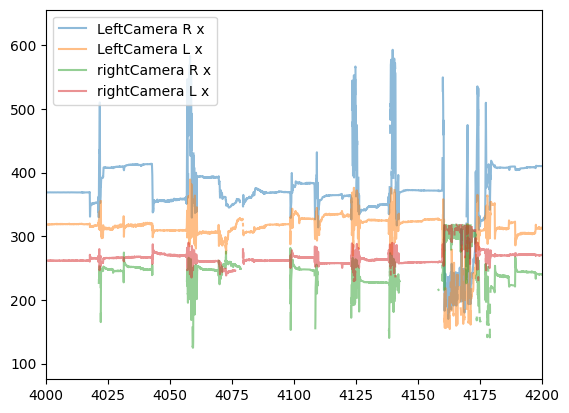

In [178]:
    # plt.plot(poses['leftCamera']['times'], zscore(poses['leftCamera']['paw_l_x']/2, nan_policy='omit'), alpha=0.5, label='LeftCamera L x')
    # plt.plot(poses['leftCamera']['times'], zscore(poses['leftCamera']['paw_l_y']/2, nan_policy='omit'), alpha=0.5, label='LeftCamera L y')

    plt.plot(poses['leftCamera']['times'], poses['leftCamera']['paw_r_x']/2, alpha=0.5, label='LeftCamera R x')
    # plt.plot(poses['leftCamera']['times'], zscore(poses['leftCamera']['paw_r_y']/2, nan_policy='omit'), alpha=0.5, label='LeftCamera R y')

    plt.plot(poses['leftCamera']['times'], poses['leftCamera']['paw_l_x']/2, alpha=0.5, label='LeftCamera L x')


    plt.plot(poses['rightCamera']['times'], poses['rightCamera']['paw_r_x']/2, alpha=0.5, label='rightCamera R x')
    # plt.plot(poses['leftCamera']['times'], zscore(poses['leftCamera']['paw_r_y']/2, nan_policy='omit'), alpha=0.5, label='LeftCamera R y')

    plt.plot(poses['rightCamera']['times'], poses['rightCamera']['paw_l_x']/2, alpha=0.5, label='rightCamera L x')

    # plt.xlim([1025, 1045])
    # plt.ylim(-2, 2)
    # plt.ylim([-500, 500])
    plt.legend()

    plt.xlim([4000, 4200])
    # plt.ylim(-5, 5)
    # plt.ylim([-500, 500])
    plt.legend()
    plt.show()

# Right camera

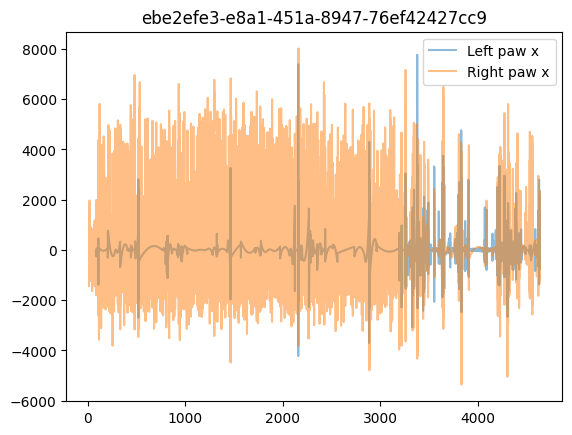

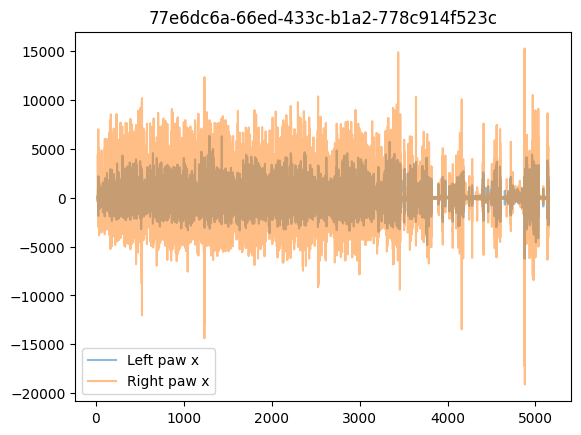

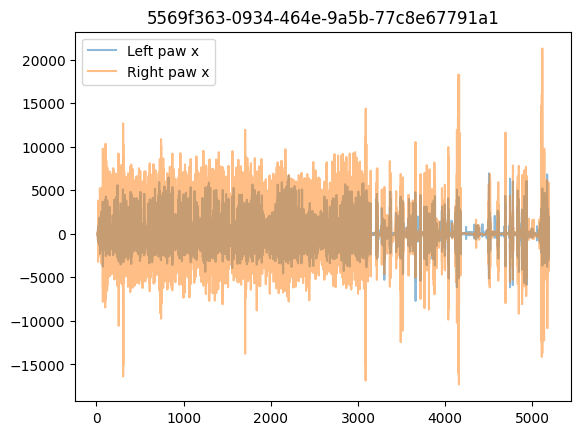

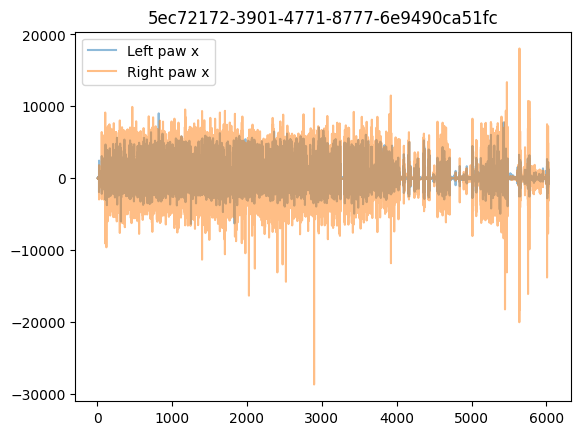

local file size mismatch on dataset: angelakilab/Subjects/NYU-39/2021-05-10/001/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-39/2021-05-10/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 113M/113M [00:24<00:00, 4.62MB/s] 


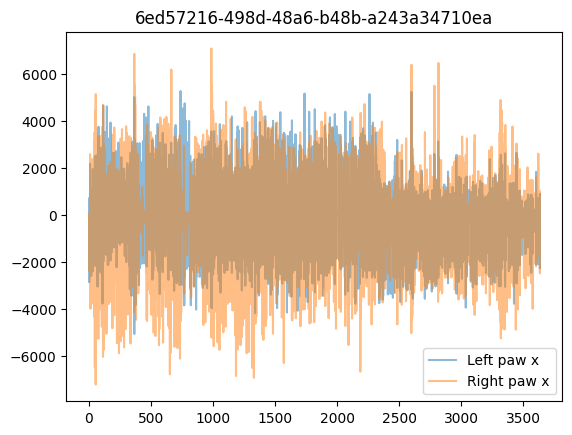

In [209]:
for s, session in enumerate(sessions[:5]):
    file_path = one.eid2path(session)
    if prefix == '/home/ines/repositories/':
        mouse_name = file_path.parts[8]
    else:
        mouse_name = file_path.parts[7]

    """ LOAD VARIABLES """
    sl = SessionLoader(eid=session, one=one)
    sl.load_pose(views=['left', 'right'], tracker='lightningPose')
    poses = sl.pose
    
    l_paw_speeds = get_speed(poses['rightCamera'], poses['rightCamera']['times'], 'right', True, feature='paw_l')
    l_paw_time = np.array(l_paw_speeds['right'][0])
    l_paw_x = l_paw_speeds['right'][1]
    l_paw_y = l_paw_speeds['right'][2]
    
    r_paw_speeds = get_speed(poses['rightCamera'], poses['rightCamera']['times'], 'right', True, feature='paw_r')
    r_paw_time = np.array(r_paw_speeds['right'][0])
    r_paw_x = r_paw_speeds['right'][1]
    r_paw_y = r_paw_speeds['right'][2]

    plt.plot(l_paw_time, l_paw_x, alpha=0.5, label='Left paw x')
    # plt.plot(l_paw_time, l_paw_y, alpha=0.5, label='Left y')

    plt.plot(r_paw_time, r_paw_x, alpha=0.5, label='Right paw x')
    # plt.plot(l_paw_time, l_paw_y, alpha=0.5, label='Left y')

    plt.title(session)
    # plt.xlim([1000, 1500])
    # plt.ylim(-2, 2)
    # plt.ylim([-500, 500])
    plt.legend()
    plt.show()

# Left camera

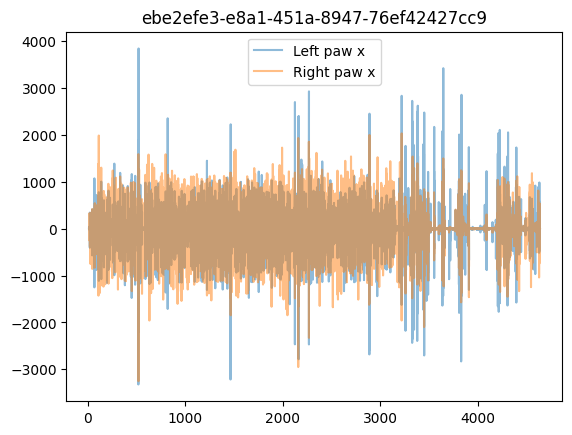

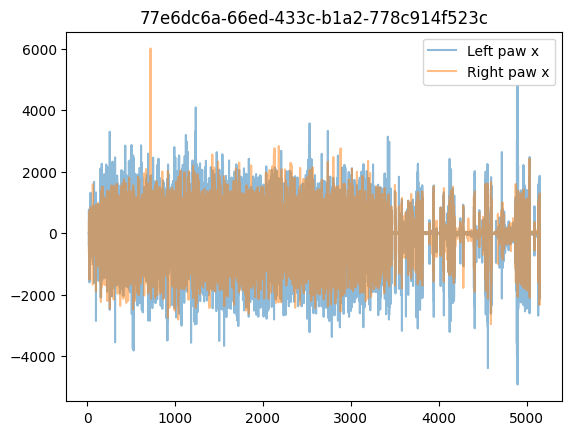

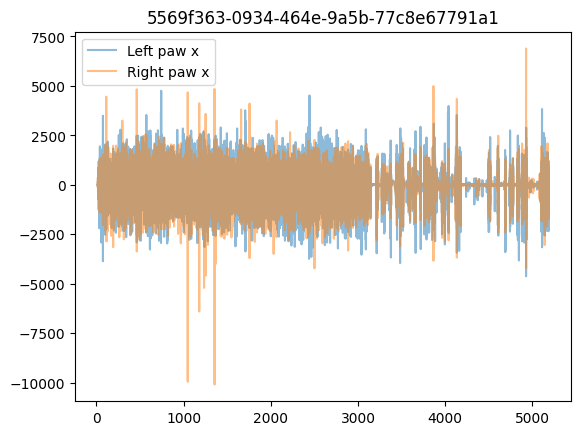

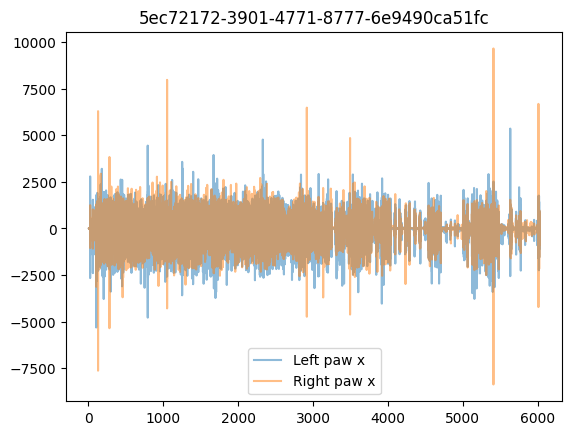

local file size mismatch on dataset: angelakilab/Subjects/NYU-39/2021-05-10/001/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-39/2021-05-10/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 113M/113M [00:36<00:00, 3.06MB/s] 


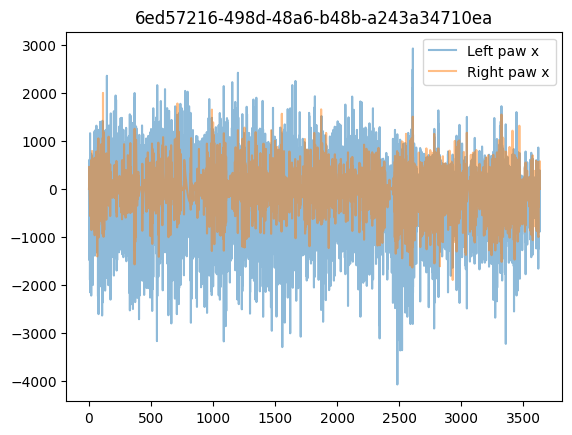

In [208]:
for s, session in enumerate(sessions[:5]):
    file_path = one.eid2path(session)
    if prefix == '/home/ines/repositories/':
        mouse_name = file_path.parts[8]
    else:
        mouse_name = file_path.parts[7]

    """ LOAD VARIABLES """
    sl = SessionLoader(eid=session, one=one)
    sl.load_pose(views=['left', 'right'], tracker='lightningPose')
    poses = sl.pose
    
    l_paw_speeds = get_speed(poses['leftCamera'], poses['leftCamera']['times'], 'left', True, feature='paw_r')
    l_paw_time = np.array(l_paw_speeds['left'][0])
    l_paw_x = l_paw_speeds['left'][1]
    l_paw_y = l_paw_speeds['left'][2]
    
    r_paw_speeds = get_speed(poses['leftCamera'], poses['leftCamera']['times'], 'left', True, feature='paw_l')
    r_paw_time = np.array(r_paw_speeds['left'][0])
    r_paw_x = r_paw_speeds['left'][1]
    r_paw_y = r_paw_speeds['left'][2]

    plt.plot(l_paw_time, l_paw_x, alpha=0.5, label='Left paw x')
    # plt.plot(l_paw_time, l_paw_y, alpha=0.5, label='Left y')

    plt.plot(r_paw_time, r_paw_x, alpha=0.5, label='Right paw x')
    # plt.plot(l_paw_time, l_paw_y, alpha=0.5, label='Left y')

    plt.title(session)
    # plt.xlim([1000, 1500])
    # plt.ylim(-2, 2)
    # plt.ylim([-500, 500])
    plt.legend()
    plt.show()

# Both paws and cameras

In [198]:
nan_ratio = pd.DataFrame(columns=['eid', 'left_paw', 'right_paw'], index=range(len(sessions)))
for s, session in enumerate(sessions):
    file_path = one.eid2path(session)
    if prefix == '/home/ines/repositories/':
        mouse_name = file_path.parts[8]
    else:
        mouse_name = file_path.parts[7]

    """ LOAD VARIABLES """
    sl = SessionLoader(eid=session, one=one)
    sl.load_pose(views=['left', 'right'], tracker='lightningPose')
    poses = sl.pose
    
    l_paw_speeds = get_speed(poses['leftCamera'], poses['leftCamera']['times'], 'left', False, feature='paw_r')
    l_paw_time = np.array(l_paw_speeds['left'][0])
    l_paw_x = l_paw_speeds['left'][1]
    
    r_paw_speeds = get_speed(poses['rightCamera'], poses['rightCamera']['times'], 'right', False, feature='paw_r')
    r_paw_time = np.array(r_paw_speeds['right'][0])
    r_paw_x = r_paw_speeds['right'][1]

    # Save
    nan_ratio['eid'][s] = session
    nan_ratio['left_paw'][s] = np.sum(np.isnan(l_paw_x))/len(l_paw_x)
    nan_ratio['right_paw'][s] = np.sum(np.isnan(r_paw_x))/len(r_paw_x)


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_35988/2908237569.py:23: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  nan_ratio['eid'][s] = session
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_35988/2908237569.py:24:

KeyboardInterrupt: 

(array([106.,   1.,   0.,   0.,   1.,   1.,   1.,   0.,   1.,   1.]),
 array([0.        , 0.05070096, 0.10140193, 0.15210289, 0.20280385,
        0.25350482, 0.30420578, 0.35490674, 0.40560771, 0.45630867,
        0.50700963]),
 <BarContainer object of 10 artists>)

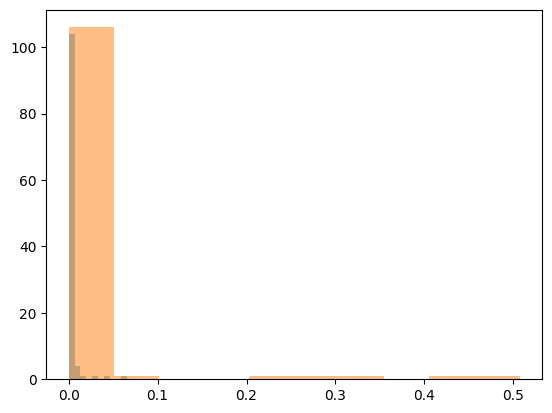

In [202]:
plt.hist(nan_ratio['left_paw'], alpha=.5)
plt.hist(nan_ratio['right_paw'], alpha=.5)

In [39]:
for s, session in enumerate(sessions[5:6]):
    file_path = one.eid2path(session)
    if prefix == '/home/ines/repositories/':
        mouse_name = file_path.parts[8]
    else:
        mouse_name = file_path.parts[7]

    """ LOAD VARIABLES """
    sl = SessionLoader(eid=session, one=one)
    sl.load_session_data(trials=True, wheel=True, motion_energy=False)

    session_trials = sl.trials
    trials_start = list(session_trials['goCueTrigger_times'])

    wheel = sl.wheel
    wheel_time = np.array(wheel['times'])
    wheel_vel = np.array(wheel['velocity'])
    
    sl.load_pose(views=['left', 'right'], tracker='lightningPose')
    poses = sl.pose
    
    l_paw_speeds = get_speed(poses['leftCamera'], poses['leftCamera']['times'], 'left', False, feature='paw_r')
    l_paw_time = np.array(l_paw_speeds['left'][0])
    l_paw_x = l_paw_speeds['left'][1]
    # l_paw_y = l_paw_speeds['left'][2]
    
    r_paw_speeds = get_speed(poses['rightCamera'], poses['rightCamera']['times'], 'right', False, feature='paw_r')
    r_paw_time = np.array(r_paw_speeds['right'][0])
    r_paw_x = r_paw_speeds['right'][1]
    # r_paw_y = r_paw_speeds['right'][2]

    """ COMMON TIMESTAMPS AND RESAMPLING"""
    # Use reference time, truncate and resample
    onset = np.max([np.min(poses['leftCamera']['times']), np.min(poses['rightCamera']['times']), np.min(wheel['times'])])
    offset = np.min([np.max(poses['leftCamera']['times']), np.max(poses['rightCamera']['times']), np.max(wheel['times'])])

    common_fs = 60
    # Set common sampling rate (high rather than low)
    reference_time = np.arange(onset, offset, 1/common_fs)  # uniform timestamps
    
    wheel_vel = wheel_vel[np.where((wheel_time >= onset) & (wheel_time < offset))]
    wheel_time = wheel_time[np.where((wheel_time >= onset) & (wheel_time < offset))]
    donwsampled_wheel, corrected_wheel_t = resample_common_time(reference_time, wheel_time, wheel_vel, kind='linear', fill_gaps=None)
    
    l_paw_time = l_paw_time[np.where((l_paw_time >= onset) & (l_paw_time < offset))]
    l_paw_x = l_paw_x[np.where((l_paw_time >= onset) & (l_paw_time < offset))]
    donwsampled_l_paw_x, corrected_l_paw_x_t = resample_common_time(reference_time, l_paw_time, l_paw_x, kind='linear', fill_gaps=None)
    l_paw_y = l_paw_y[np.where((l_paw_time >= onset) & (l_paw_time < offset))]
    donwsampled_l_paw_y, corrected_l_paw_y_t = resample_common_time(reference_time, l_paw_time, l_paw_y, kind='linear', fill_gaps=None)

    r_paw_time = r_paw_time[np.where((r_paw_time >= onset) & (r_paw_time < offset))]
    r_paw_x = r_paw_x[np.where((r_paw_time >= onset) & (r_paw_time < offset))]
    donwsampled_r_paw_x, corrected_r_paw_x_t = resample_common_time(reference_time, r_paw_time, r_paw_x, kind='linear', fill_gaps=None)
    r_paw_y = r_paw_y[np.where((r_paw_time >= onset) & (r_paw_time < offset))]
    donwsampled_r_paw_y, corrected_r_paw_y_t = resample_common_time(reference_time, r_paw_time, r_paw_y, kind='linear', fill_gaps=None)

2025-07-29 18:04:52 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-07-29 18:04:55 INFO     one.py:1288 Loading wheel data
2025-07-29 18:04:56 INFO     one.py:1288 Loading pose data
2025-07-29 18:04:58 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-07-29 18:04:58 WARNING  one.py:1292 Could not load pupil data.


local file size mismatch on dataset: angelakilab/Subjects/NYU-39/2021-05-11/001/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-39/2021-05-11/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 114M/114M [00:30<00:00, 3.77MB/s] 


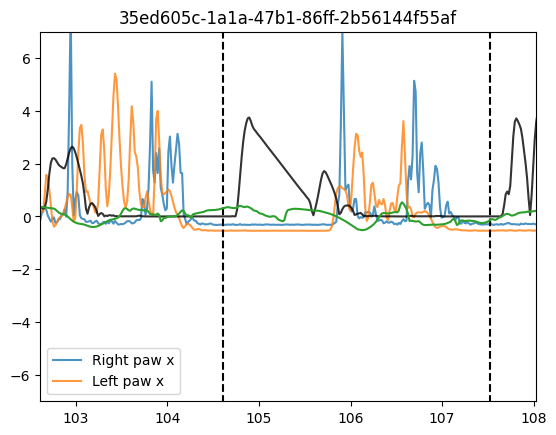

In [40]:
    plt.plot(corrected_r_paw_x_t, zscore(donwsampled_r_paw_x, nan_policy='omit'), alpha=0.8, label='Right paw x')
    plt.plot(corrected_l_paw_x_t, zscore(donwsampled_l_paw_x, nan_policy='omit'), alpha=0.8, label='Left paw x')
    plt.plot(corrected_wheel_t, np.abs(donwsampled_wheel), alpha=.8, color='k')
    plt.vlines(trials_start, -20, 20, linestyles='--', color='k')
    plt.title(session)
    correlations = sliding_window_correlation(zscore(donwsampled_l_paw_x, nan_policy='omit'), 
                                              zscore(donwsampled_wheel, nan_policy='omit'), window_size=60)
    plt.plot(corrected_wheel_t, correlations)

    trial_to_plot = 20
    beg = trials_start[trial_to_plot]-2
    end = trials_start[trial_to_plot+1]+.5
    plt.xlim([beg, end])
    plt.ylim(-7, 7)
    # plt.ylim([-500, 500])
    
    plt.legend()
    plt.show()

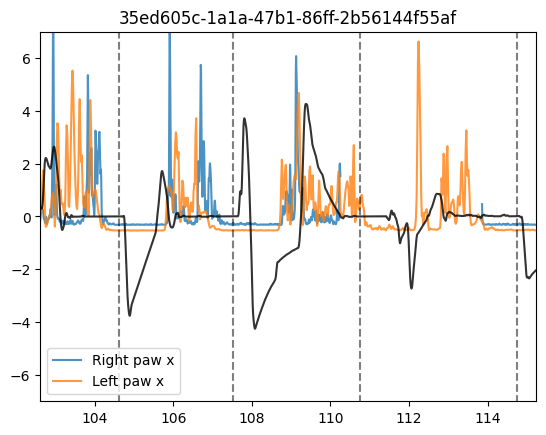

In [38]:
    plt.plot(r_paw_time, zscore(r_paw_x, nan_policy='omit'), alpha=0.8, label='Right paw x')
    # plt.plot(r_paw_time, r_paw_y, alpha=0.5, label='Right y')
    plt.plot(l_paw_time, zscore(l_paw_x, nan_policy='omit'), alpha=0.8, label='Left paw x')
    # plt.plot(l_paw_time, l_paw_y, alpha=0.5, label='Left y')
    plt.plot(wheel_time, wheel_vel, alpha=.8, color='k')
    plt.vlines(trials_start, -20, 20, linestyles='--', color='k', alpha=.5)

    trial_to_plot = 20
    beg = trials_start[trial_to_plot]-2
    end = trials_start[trial_to_plot+3]+.5
    plt.xlim([beg, end])
    plt.ylim(-7, 7)
    plt.title(session)
    plt.legend()
    plt.show()

In [ ]:
len()